In [1]:
#hidden cell to be executed BEFORE the presentation
import warnings
warnings.filterwarnings('ignore')
import sys
path = './dftpy/src' # If DFTpy is not in PYTHONPATH, change it to the path of where dftpy/src is located.
if path not in sys.path:
    sys.path.insert(0, path)
from IPython.display import IFrame
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from IPython.lib.display import YouTubeVideo
file1='Al_lda.oe01.recpot'
PP_list = {'Al': './dftpy/examples/DATA/'+file1}

In [2]:
#hidden cell to be executed BEFORE the presentation
from ase_notebook import AseView, ViewConfig
config = ViewConfig()
ase_view = AseView(config)
ase_view = AseView(
    rotations="45x,45y,45z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(700, 300),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
#ase_view.add_miller_plane(
#    1, 0, 0, color="green")
ase_view.config
ase_view.config.canvas_color_background = "blue"
ase_view.config.canvas_background_opacity = 0.2

def view (ions):
    gui = ase_view.make_render(
    ions, center_in_uc=True)
    return gui
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
gui=view(ions)
gui
print('Done with preambles')

Done with preambles


<center>
    <h1>Cracking Challenging Electronic Structures</h1>
    <h3>Embedding $\cdot$ Machine Learning $\cdot$ Orbital-Free DFT </h3>
<center>
<br>
    <br>
<table>
  <tr>
      <td><p><h1>Michele Pavanello</h1></p><p style="color:blue">@MikPavanello</p><p><h2>Rutgers University-Newark</h2></p></td>
      <td><img src="figures/logos/run.png" width=250 height=250 /></td>
  </tr>
  <tr>
    <td></td>
    <td> http://prg.rutgers.edu</td>
  </tr>
  <tr>
    <td></td>
    <td> https://gitlab.com/pavanello-research-group/vista_seminar </td>
  </tr>
</table>

#### VISTA seminars -- October 5, 2022


# Acknowledgements

<table>
  <tr>
      <td><p><h3>Students</h3></p><p>Dr Xuecheng Shao</p><p>Dr Kaili Jiang</p><p>Jessica Martinez</p><p>Andres Cifuentes</p><p>Valeria Rios </p><p>2 HS students</p></td>
      <td><img src="figures/prg_pics/prg_2021.png" width=800 /></td>
  </tr>
</table>

Funding: NSF, DOE, MolSSI, ACS-PRF, Rutgers

# The Real World
<table>
    <tr>
      <td><h3>Photocatalyst</h3></td>
        <td><h3>Catalytic nanoparticles</h3></td>
  </tr>
  <tr>
      <td><img src="figures/science/photocatalyst.png" height=500 /></td>
      <td><img src="figures/science/catalyst.png" height=500 /></td>
  </tr>
    <tr>
        <td>Chem. Comm., 43, 6551 (2009)</td>
        <td>PCCP, 21, 15080 (2019)</td>
    </tr>
</table>   

# (some of the) Available electronic structure methods
<br>
<center>
    <img src="figures/science/electronic_structure.png" width=1600 />
</center>

# An option: Orbital-free DFT (OF-DFT)
<br>

<center>
<ul>
    <li><p><b>OF-DFT</b> is exactly like DFT but <b>with only one orbital</b>!</p></li>
    <li><p>The variational function is the electron density <u>only</u></p> 
        <p>$$n(\mathbf{r})=N |\psi(\mathbf{r})|^2$$</p></li>
    <li><p>The energy functional is a pure functional of $n(\mathbf{r})$</p>
        <p>$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} $$</p></li>
    <li><p>Ground state is found by direct minimization</p>
        <p>$$n_0(\mathbf{r})=\text{argmin}_n\left[ E[n]-\mu \left(\int n(\mathbf{r})d\mathbf{r}-N\right)\right]$$</p></li>
</ul>
</center>
<table>
    <tr>
        <td><div class="alert alert-block alert-success"><center><b>Opportunity:</b> No need to diagonalize any matrix!</center></div></td>
        <td><div class="alert alert-block alert-danger"><center><b>Problem:</b> $T_s[n]$ exists, but it is not known...</center></div></td>
    </tr>
</table>




### OF-DFT's $T_s[n]$: (semi)local and nonlocal functionals
<br>
<center>
    <img src="figures/science/local_nonlocal.png" width=1600 />
<p>Wenhui Mi, MP JCP (2018) • Wenhui Mi, MP PRB (2019) • Xuecheng Shao, WM, MP PRB (2021)
Xuecheng Shao, WM, MP JPCL (2021) • Xuecheng Shao, WM, MP JCTC (2021) • Wenhui Mi, MP JPCL (2020)</p>
    </center>

<center><div class="alert alert-block alert-danger">
    Ok... but it is really much faster than KS-DFT?
</div> 
    </center>

# OF-DFT in practice
### How hard is it to run an OF-DFT simulation?

<table>
    <tr>
        <td><b><center>Computational workflow</b></center></td><td><b><center>Do it yourself!</b></center></td>
    <tr>
        <td>
            <p>1. Generate a model system </p>
            <p>2. Set up an OF-DFT simulation engine </p>
            <p>3. Pick a $T_s[n]$, <b>noninteracting kinetic energy density functional</b> (KEDF) </p>
            <p>4. Define "total energy" and <b>minimize</b> $E[n]$ $\to n(\mathbf{r})$!! </p>
        </td>
        <td>
            <img src="figures/random/dftpy_notebook_qr.png" width=400 />
        </td>
    </tr>

1. Generate a model system: bulk Al (cubic cell) with ASE

In [3]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
view(ions)

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(aspect=2.3333333333333335, fov=10.0, position=(0.0,…

2. Set up an OF-DFT simulation with `DFTpy` 

In [4]:
nr = ecut2nr(ecut=35, lattice=ions.cell)
grid = DirectGrid(lattice=ions.cell, nr=nr)
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume
HARTREE = Functional(type='HARTREE')
XC = Functional(type='XC',name='LDA')

setting key: Al -> ./dftpy/examples/DATA/Al_lda.oe01.recpot


In [5]:
IFrame('http://dftpy.rutgers.edu', width=1000, height=400)

3. Pick a noninteracting kinetic energy density functional (KEDF), $T_s[n]$. In this example we use Thomas Fermi + von Weizsacker:
$$T_s[n] = \int C_{TF} ~n^{5/3}(\mathbf{r})~ d\mathbf{r} + \int \frac{\nabla n^{1/2}(\mathbf{r})\cdot \nabla n^{1/2}(\mathbf{r})}{2} ~d\mathbf{r}$$

In [6]:
KE = Functional(type='KEDF',name='x_TF_y_vW')

4. Define "total energy" and minimize $E[n]$

In [7]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
optimization_options = {'econv' : 1e-6*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')
%timeit -n1 -r1 rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       4.128385E-02    
1       2.509905170337E+00      -1.822483E-01   7.033208E-02    2       1       5.538297E-02    
2       2.502273081666E+00      -7.632089E-03   4.803519E-03    7       1       8.563471E-02    
3       2.502030159560E+00      -2.429221E-04   3.640588E-04    5       1       1.111939E-01    
4       2.501995243576E+00      -3.491598E-05   3.590654E-05    6       1       1.441627E-01    
5       2.501992596729E+00      -2.646848E-06   2.500656E-06    5       1       1.656740E-01    
6       2.501992226202E+00      -3.705265E-07   4.567333E-08    8       1       1.997540E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.301151965392965
Chemical potential (eV)  : 8.194761600376985
202 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<center><div class="alert alert-block alert-success">
    OF-DFT with semilocal functionals is two+ orders of magnitude faster than KS-DFT
</div> 
    </center>

# OF-DFT with nonlocal $T_s[n]$ can approach semiconductor bulk!

<center>
    <br>
    <p style="font-size:100%; text-align:center;">Huang & Carter, Phys. Rev. B <b>81</b>, 045206 (2010)</p>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/huang_carter.png" width=600 />
    <div class="alert alert-block alert-success">Excellent results for bulk semiconductors and metals!</div>
</center>

# OF-DFT with nonlocal $T_s[n]$ can approach semiconductor surfaces!

<center>
    <br>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/ofdft_surfaces.png" width=1800 />
    <div class="alert alert-block alert-success">Excellent results for semiconductors and metal surfaces!</div>
</center>

# What else can OF-DFT do?
<br>
<center>
    <p style="font-size:100%; text-align:center;"> J. Phys. Chem. Lett. <b>12</b>, 4134 (2021) &#x25C6; WIREs: Comp. Mol. Sci. <b>11</b>, e1482 (2021)</p>
    <br>
    <img src="figures/science/ofdft_showoff.png" width=1600 />
    <div class="alert alert-block alert-success">How about optical spectra and dynamics? $\ldots$ talk to me after the session!</div>
</center>

# OF-DFT has an Achilles heel...
<ul>
    <li>OFDFT does not use KS orbitals</li>
    <li>KSDFT relies on pseudopotentials, which have local and a <b>nonlocal</b> parts</li>
    <li>OFDFT can only use <b>local pseudopotentials</b></li>
</ul>

<center>
<table>
    <tr>
        <td><p><b><center>The Periodic Table</center></b></p></td>
        <td>&#8594;</td>
        <td><p><b><center>OFDFT's Periodic Table</center></p></b></td>
    </tr>
    <tr>
        <td><img src="figures/science/periodic_all.png" width=600/></td>
        <td>&#8594;</td>
        <td><img src="figures/science/periodic_ofdft.png" width=600/></td>
    </tr>
</table>
</center>

<h3>No transition metals, no second row elements...</h3>

<center>
    <h1>We can't put all of our eggs in the OF-DFT basket</h1>
    <br>
    We need alternative methods to approach the mesoscale. They need to:
    <p>
    <ul>
        <li> <b>First:</b> scale computationally at most as $\mathcal{O}[Nln(N)]$ (like OF-DFT)</li>
        <li> <b>Second:</b> approach realistic system sizes without using an entire supercomputer (no need for exascale)!</li>
        <li> <b>Third:</b> be accurate </li>
    </ul>
    </p>
    <h2>Shall we try Subsystem DFT?</h2>
</center>

# Subsystem DFT (sDFT) - Theory

<div class="alert alert-block alert-warning">
    <ul>
        <li>Split system into (smaller) subsystems: $n(\mathbf{r})=\sum_I n_I(\mathbf{r})$</li>
        <li>Use KS-DFT <b>or</b> OF-DFT for the subsystems</li>
        <li><p>Energy is split in <i>additive</i> and <i>non-additive</i> terms:</p><p>$$E[n]\equiv E[\{n_I\}]=\sum_I E[n_I] + E^{nadd}[\{n_I\}]$$</p></li>
    </ul>
</div>

<div class="alert alert-block alert-warning">
    <ul>
        <li><p>The nonadditive energy given by:</p><p>$$E^{nadd}[\{n_I\}] = E[n] - \sum_IE[n_I] \to \\
        \to \tilde T_s^{nadd}[\{n_I\}]+E_{xc}^{nadd}[\{n_I\}]+ \text{Coulomb interactions between subsystems}$$</p></li>
    </ul>
</div>

<div class="alert alert-block alert-danger">
<b>Problem:</b> Must use approximate non-additive kinetic energy, $T_s^{nadd}[\{n_I\}]$
</div>
<div class="alert alert-block alert-success">
    <b>Opportunity:</b> We can use <i>accurate non-local</i> $T_s^{nadd}[\{n_I\}]$, previously developed for OF-DFT!
</div>

# Subsystem DFT (sDFT) - Timings
<br>
<center>
<img src="figures/science/sdft_timings.png" width=1300 />
</center>
<ul>
    <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
    <li> Int. J. Quantum Chem. <b>117</b> e25401 (2017)</li>
    <li> J. Phys. Chem. Lett. <b>10</b> 7554 (2019)</li>
</ul>
<div class="alert alert-block alert-success">
    <b>sDFT timings are exactly right!</b>
</div>

# How accurate is sDFT? ... the S66 set
<table>
    <tr>
        <td> <center><b> KSDFT and sDFT (with +D4)</center></b></td>
        <td></td>
        <td> <center><b> RMSD comparison </center></b></td>
    </tr>
    <tr>
        <td>
            <center>
                <img src="figures/science/sdft_s66.png" width=600 />
            </center>
        </td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>
            <center>
                <img src="figures/science/s66_comparisons.png" width=700 />
            </center>
        </td>
    </tr>
    <tr>
        <td>
            <ul>
                <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
                <li> J. Chem. Theory Comput. <b>17</b> 3455 (2021)</li>
                <li> J. Phys. Chem. Lett. <b>11</b> 272 (2020)</li>
            </ul>
        </td>
        <td>
        </td>
        <td>
            <ul>
                <li> J. Chem. Theory Comput. <b>7</b> 2427 (2011)</li>
            </ul>
        </td>
    </tr>
    </tr>
</table>
<div class="alert alert-block alert-success">
    <b>sDFT approaches weakly interacting subsystems correctly and almost as accurately as nonlocal KS-DFT</b>
</div>

# What happens when subsystems interact strongly?
<br>
When subsystems come close and interact strongly
<center>
<img src="figures/science/merging_splitting.png" width=600 />
    <br>
    ... a chemical reaction may take place $\to$ sDFT's non-additive functionals are <b>not good enough for this!</b>
</center>

<div class="alert alert-block alert-warning">
    <b> <center> We need an "adaptive" sDFT method</center></b>
</div>

<ul style="text-align: left; font-size: 100%; line-height:90%;margin-top: 0; margin-bottom: 0;">
    <li> <i>Automatically</i> "split" and "merge" subsystems along a dynamics or relaxation</li>
    <ul>
        <li> computational setting: basis set, smearing, charge, etc$\ldots$</li>
        <li> redefine MPI communicators on-the-fly (yes it's all done in parallel)</li>
    </ul>
</ul>
<div class="alert alert-block alert-danger">
    <b> <center> Might it be too hard?</center></b>
</div>

# "Adaptive" sDFT

<table>
    <tr>
        <td>
            <center>NaCl in water $\to$ Na$^+_{\rm (aq)}$ + Cl$^-_{\rm (aq)}$</center>    
            <ul>
                <li> Na and Cl slowly dissociate to their solvated ions</li>
                <li>100+ water molecules, Na$^+$ and Cl$^-$ in a box</li>
                <li> NVT ab-initio dynamics for a few picoseconds</li>
                <li> H$_2$O molecules <b>interact strongly</b> with both ions</li>
            </ul>
        </td>
        <td><img src="figures/science/qr_adaptive.png" width=400 align="right" /></td>
    </tr>
</table>

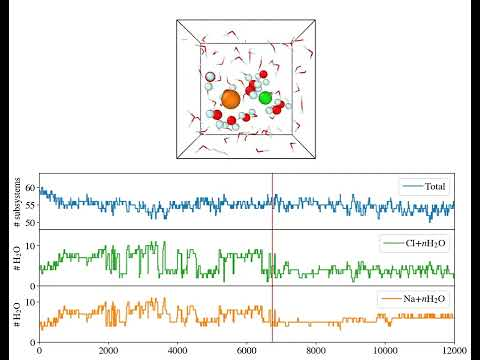

In [8]:
YouTubeVideo('-lmdPHzJfeU', width=800, height=500)

# We all have a thing for light-matter interactions

<ul>
    <li>The computational scaling of excited state electronic structure methods is steeper than for ground states</li>
    <li>The possibility of using OFDFT or sDFT for excited states is <b>exciting</b>!</li>
</ul>
<br>

<center>
    <b style="color:red"> A biased look at the literature</b>
    <br>
<table style='font-family:"monospace; font-size:100%'>
        <tr><td><b><center>Time-dependent sDFT</center></b></td><td><b><center>Comments</center></b></td><td><b><center>Time-dependent OFDFT</center></b></td><td><b><center>Comments</center></b></td></tr>
        <tr><td>M. E. Casida..., IJQC 96, 577 (2004)</td><td>LR formalism</td><td>M. Horbatsch..., Z. Phys. A 300, 119 (1981)</td><td>Time-dep. TF model</td></tr>
        <tr><td>J. Neugebauer, JCP 126, 134116 (2007)</td><td>LR spectra</td><td>F. Della Sala JCP 157, 104101 (2022)</td><td>LR plasmonics</td></tr>
        <tr><td>J. Neugebauer, JCP 131, 084104 (2009)</td><td>LR response properties</td><td>Covington... PRB 103, 075119 (2021)</td><td>RT + Maxwell</td></tr>
        <tr><td>J. Neugebauer..., JCTC 6, 1843 (2010)</td><td>LR solvent screening</td><td>D. Neuhauser..., JCP 134, 144101 (2011)</td><td>Nonadiabatic Pauli</td></tr>
        <tr><td>K. König..., JCP 138, 034104 (2013)</td><td>LR TDA</td><td>A. J. White ..., PRB 98, 144302 (2018)</td><td>Nonadiabatic RT + Ehrenfest</td></tr>
        <tr><td>M. Pavanello, JCP 138, 204118 (2013)</td><td>LR formalism</td><td>D. I. Palade..., JPB 48, 185102 (2015)</td><td>optical response</td></tr>
        <tr><td>R. Kevorkyants..., JCP 141, 044127 (2014)</td><td>LR nonlocal correlation</td><td>K. Jiang..., PRB 103, 245102 (2021)</td><td>Nonadiabatic Pauli</td></tr>
        <tr><td>A. Krishtal..., JCP 142, 154116 (2015)</td><td>RT implementation</td><td>K. Jiang..., PRB 104, 235110 (2021)</td><td>Nonadiabatic RT optical spectra</td></tr>
        <tr><td>S. Kumar P...., JCPL 8, 5077 (2017)</td><td>RT spectra of liquids</td><td>K. Jiang..., PRB 106, 115153 (2022)</td><td>Fast nonadiabatic RT</td></tr>
        <tr><td>A. Umerbekova..., EPJ B 91, 1 (2018)</td><td>RT interfaces</td><td>L. Bhan..., Nano Lett. 22, 4240 (2022)</td><td>Nanostructure engineering</td></tr>
        <tr><td>X. Shao..., Electron. Struct. 4, 024001 (2022)</td><td>RT many-body dispersion</td><td>P. Zimmerer..., PLA 134, 57 (1988)</td><td>Semiclassical</td></tr>
</table>
</center>

# A few words about the underlying formalism
<br>
<table>
    <tr><td></td><td>&nbsp;&nbsp;&nbsp;&nbsp;</td><td style="border-right: 1px solid blue;"><center><b>TD-OFDFT</b></center></td><td><center><b>TD-sDFT</b></center></td></tr>
    <tr><td>Hamiltonian</td><td></td><td style="border-right: 1px solid blue;">$$\hat{H}_{\rm OF}=-\frac{1}{2}\nabla^2 + v_s(r,t) + v_P(r,t)$$</td><td>$$\hat{H}_{I}=-\frac{1}{2}\nabla^2 + v_s[n_I](r,t) + v_{\rm emb}[\{n_{J}\}](r,t)\qquad \forall I \in \{1\ldots N_S\}$$</td></tr>
    <tr><td>Effective Schrödinger Eq.</td><td></td><td style="border-right: 1px solid blue;">$$i\frac{d \Psi(r,t)}{dt}=\hat{H}_{\rm OF}\Psi(r,t)$$</td><td>$$i\frac{d \phi_k^I(r,t)}{dt}=\hat{H}_{\rm I}\phi_k^I(r,t)\qquad\forall k\in \{1\ldots N_I\}$$</td></tr>
    <tr><td>Density linear response</td><td></td><td style="border-right: 1px solid blue;">$$\chi_s=\chi_B + \chi_B f_P \chi_s\\ \chi = \chi_s + \chi_s f_{Hxc} \chi$$ </td><td>$$\chi = \sum_I^{N_S} \chi_I, \,\,\, \chi_I^u = \chi_I^s+ \chi_I^s f_{Hxc} \chi_I^u\\  \chi_I = \chi_I^u + \chi_I^u \sum_J^{N_S}\left[ f_{Hxc} + f_{T_s} - \delta_{IJ}f_{T_s}^I\right] \chi_J$$</td></tr>
    <tr><td>Main approximations</td><td></td><td style="border-right: 1px solid blue;">$$v_P(r,t)\text{  or  }f_P$$</td><td>$$v_{T_s}^{\rm nad}(r,t)\text{  or  }f_{T_s} - \delta_{IJ}f_{T_s}^I$$</td></tr>
</table>

<div class="alert alert-block alert-success">
    Implementation in open-source software <b>in Python</b>!
    <br>
    <ul>
    <li>TD-OFDFT in DFTpy - dftpy.rutgers.edu</li>
    <li>TD-sDFT in eDFTpy - edftpy.rutgers.edu</li>
    </ul>
</div>

<div class="alert alert-block alert-warning">
    <b>Warning</b>: What follows is a biased story - but is a good one <img style="display: inline-block" src="figures/random/smile.png" width=30 />
</div>

# What can TD-OFDFT do?
<br>
<b>Optical spectrum of Si$_{30}$H$_{40}$</b>
<center>
    <img src="figures/science/Si30H40.png" width=500 align="center" />
</center>

<b>Passivation of Si nanoparticles with H-atoms</b>
<center>
    <img src="figures/science/Si_passivation.png" width=900 align="center" />
</center>

# What can TD-OFDFT do?
<br>
<b>Spectra of semiconductor nanoparticles, the case of passivated Ga$_{152}$As$_{152}$</b>
<br>
<center>
<img src="figures/science/Ga152As152.png" width=1200 align="center" />
</center>

# What can TD-sDFT do?
<br>
<center>
    <b>Properties of water in wet MoS$_2$</b>
    <img src="figures/science/mol.png" width=850 align="center" />
</center>

- Access to spectra and dipole polarizabilities of each of the 64 water molecules in the model
- Fluctuation-dissipation to obtain C6 coefficients (from the time-dependent dipole moment of each subsystem)
- <b>Subsystem-local</b> quantities and their <b>change due to coupling with the environment</b>

# What can TD-sDFT do?
<br>
<center>
    <b>Spectra of single water molecules in wet MoS$_2$</b>
    <img src="figures/science/hs3.png" width=1000 align="center" />
</center>

# What can TD-sDFT do?
<br>
<center>
<table>
    <tr><td><b><center>C6 coefficients</center></b></td><td><b><center>Excitation energy, $\omega$</center></b></tr>
    <tr><td><img src="figures/science/c6.png" width=700 align="center" /></td><td><img src="figures/science/omega.png" width=700 align="center" /></td></tr>
    <tr><td><center>C6 and its surface coupling, $\Delta$C6, follow same trend</center></td><td><center>$\omega$ and its surface coupling, $\Delta\omega$, follow opposite trend </center></td></tr>
</table>
</center>

<center>
    <h1>The End...</h1>
    <br>
    <br>
    <br>
    <table>
        <tr>
            <td style="text-align:center;"><b>We discussed:</b></td>
            <td style="text-align:center;"><b style="color:red;">We didn't discuss:</b></td>
        </tr>
        <tr>
            <td>
                <ul>
                    <li> Orbital-Free DFT</li>
                    <li> Subsystem DFT</li>
                    <li> Adaptive Subsystem DFT</li>
                    <li> Orbital-Free TDDFT</li>
                    <li> Subsystem TDDFT </li>
                </ul>
            </td>
            <td>
                <ul style="color:red;">
                    <li> "Orbital-Free in Kohn-Sham" Embedding</li>
                    <li> Wavefunction-in-DFT Methods</li>
                </ul>
            </td>
    </table>
    <br>
    <br>
    <br>
    <h1>Thank you!</h1>
</center>